# Ethnogeographic diversity of Ethiopia

Define "ethnic diversity" of a region as the probability that any two randomly selected people in the region will belong to different ethnic groups. From a population histogram, it can be computed as follows:

In [1]:
def diversity(p):
    n = sum([p_i*p_i for p_i in p])
    s = p.sum()
    return 1.0 - n/(s*s)

Using [data from the 2007 census](data), we can compute ethnic diversity at the district level.  The data is only available in PDF format, so we need [a custom parser](census_pdf_parser.py) based on [tabula](https://tabula.technology/).

In [2]:
import census_pdf_parser

files= [
    'data/Addis_Ababa_Statistical-table_3.1.pdf',
    'data/Affar_Statistical-table_3.1.pdf',
    'data/Statistical_Amhara-table_3.1.pdf',
    'data/Benishangu_Gumuz_Statistical-table_3.1.pdf',
    'data/Dire_Dawa_Statistical-table_3.1.pdf',
    'data/Gambella_Statistical-table_3.1.pdf',
    'data/Harari_Statistical-table_3.1.pdf',
    'data/Statistical_Oromiya-table_3.1.pdf',
    'data/Statistical_SNNPR-table_3.1.pdf',
    'data/Somali_Statistical-table_3.1.pdf',
    'data/Tigray_Statistical-table_3.1.pdf'
]
tables = {}

for filename in files:
    for name, table in census_pdf_parser.process_file(filename):
        if name in tables:
            name += '~'
        tables[name] = table

print(len(files), 'files.', len(tables), 'tables.' )

11 files. 104 tables.


In [3]:
import pandas as pd

df = pd.DataFrame(columns=['name', 'diversity', 'population'])

for name,t in tables.items(): 
    if not name:
        continue
    v = t.loc[t.index!='All Groups'][1].dropna()
    df = df.append([{'name': name, 'diversity': diversity(v), 'population': v.sum()}], 
                   ignore_index=True)

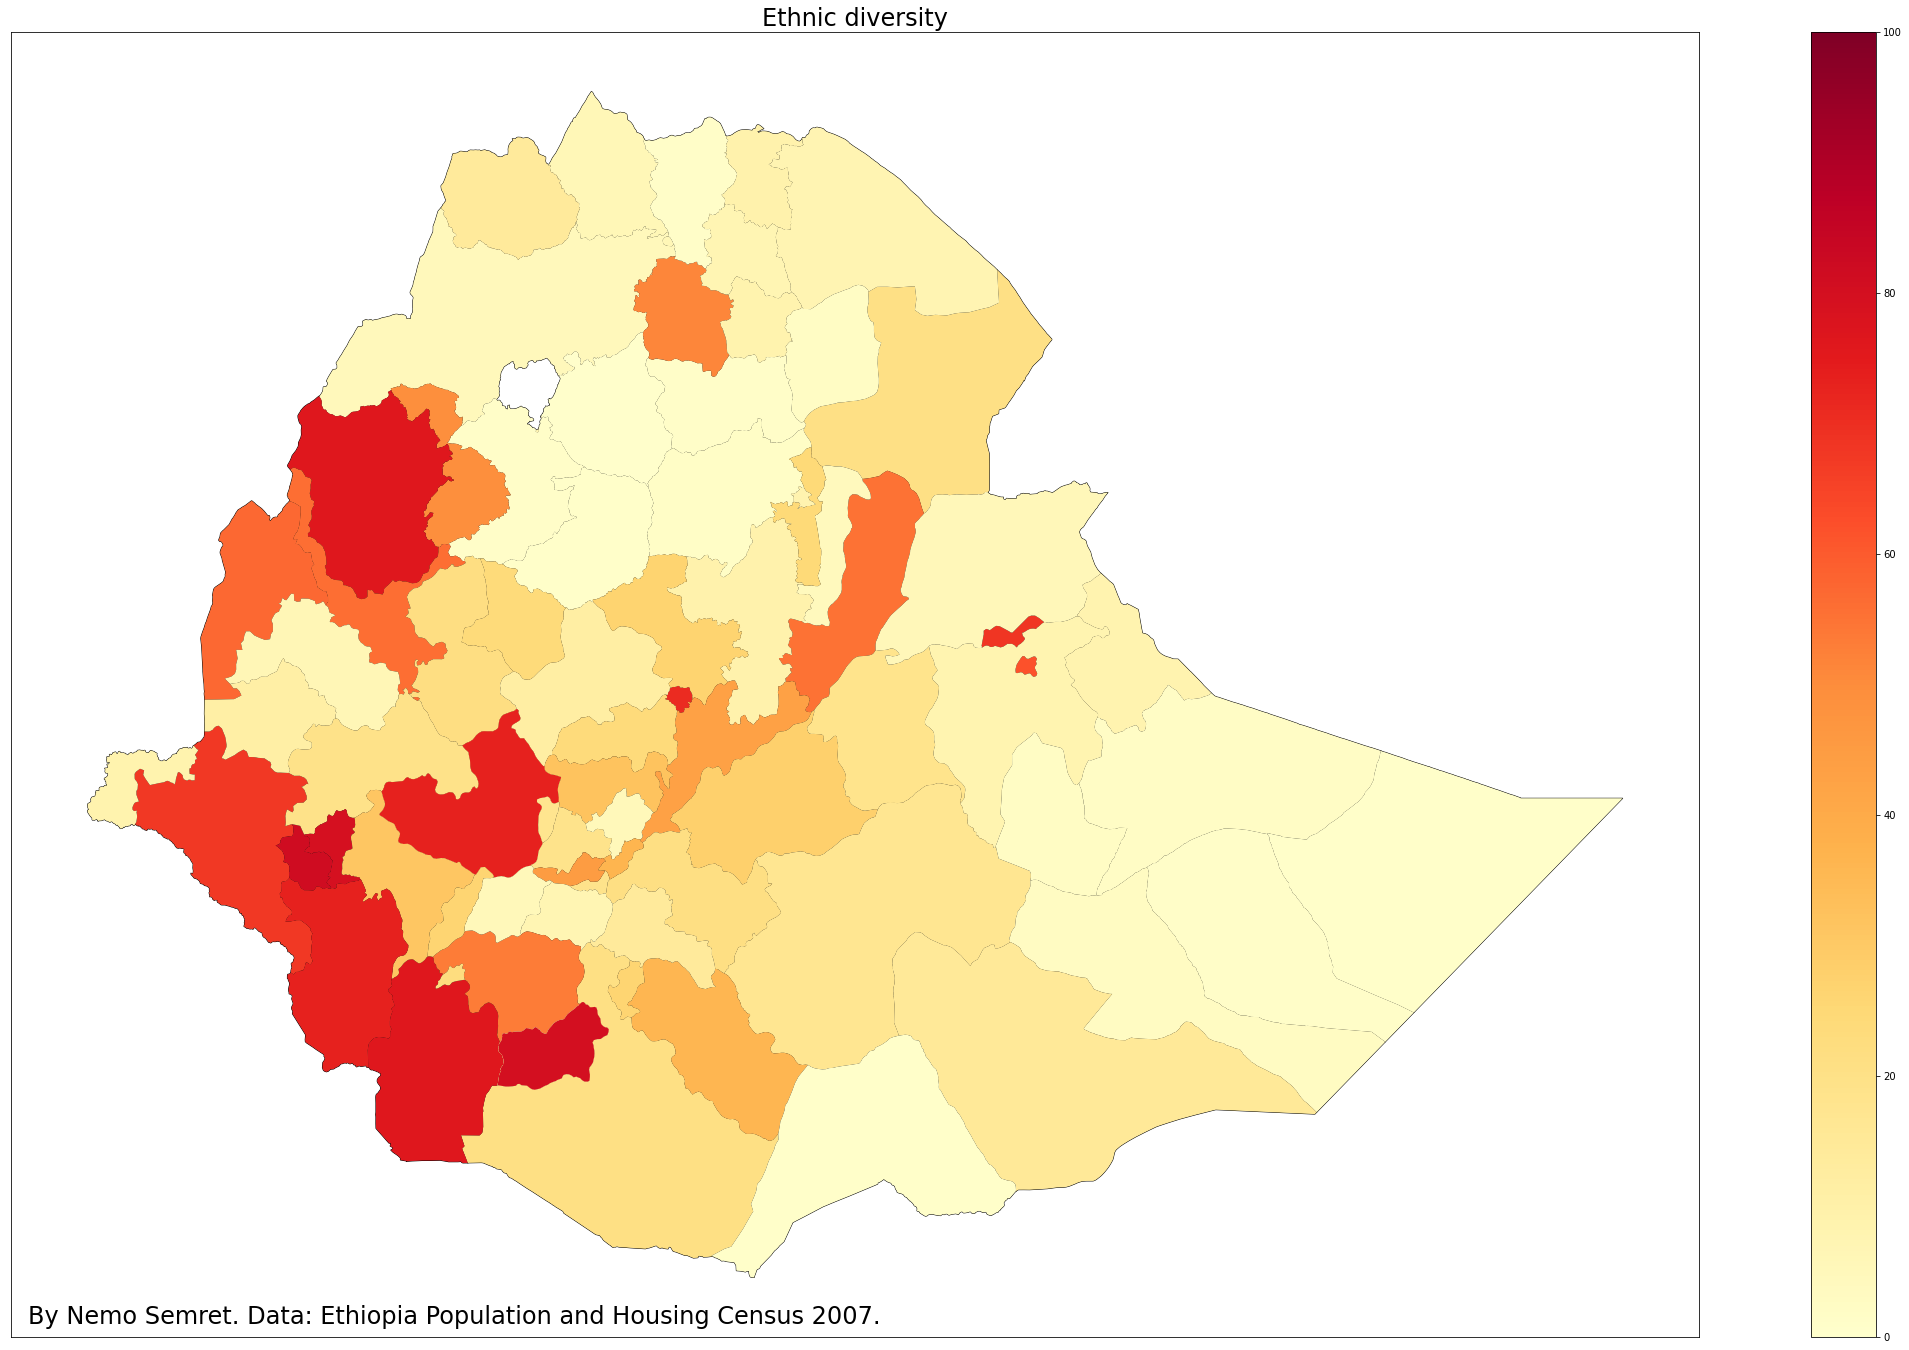

In [4]:
import matplotlib.pyplot as plt
import geopandas
from regions import region_mapping, get_geometry

rdf = pd.DataFrame(data=region_mapping.items(), columns=['name', 'region_id'])
rdf = rdf.merge(df, how='left', on='name')

geo_data = []

for r in rdf[['region_id', 'diversity', 'population', 'name']].values:
    if pd.isna(r[0]):
        continue
    geo_data.append({
        'region_id': int(r[0]),
        'geometry': get_geometry(int(r[0])),
        'diversity': 100*r[1],
        'population': r[2],
        'name': r[3]
    })

gdf = geopandas.GeoDataFrame(geo_data)

fig, axes = plt.subplots(1, 1, figsize=(40,24))
gdf.plot(ax=axes, edgecolor='black', facecolor='lightgray')
gdf.plot(column='diversity',  cmap='YlOrRd', vmin=0, vmax=100, 
         ax=axes, legend=True)
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
axes.set_title('Ethnic diversity', fontsize=24)
axes.text(0.01, 0.01, 'By Nemo Semret. Data: Ethiopia Population and Housing Census 2007.', fontsize=24, transform=axes.transAxes)
plt.show()

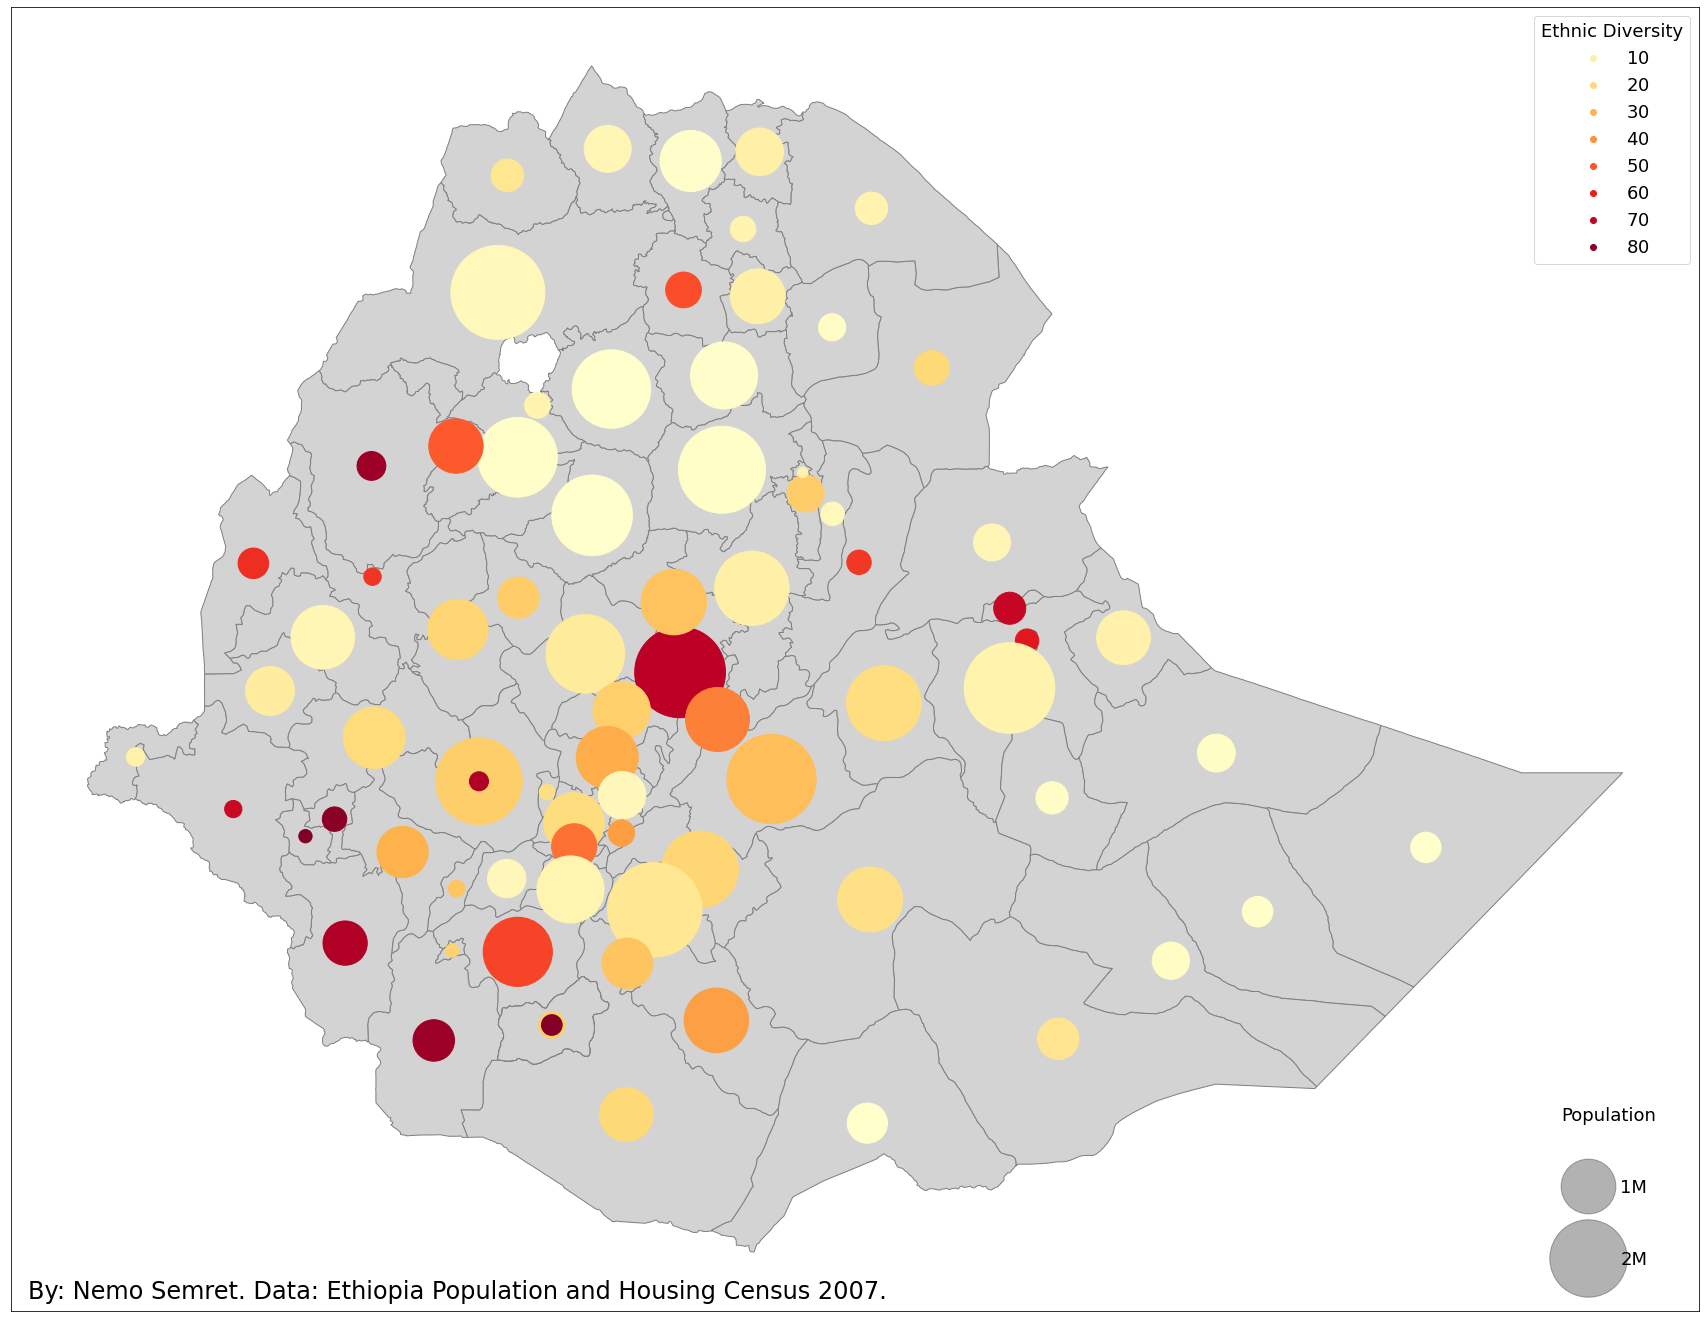

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(40,24))
gdf.plot(ax=axes, edgecolor='gray', facecolor='lightgray')
gtmp = gdf.dropna(subset=['geometry'])
d = plt.scatter(list(map(lambda p: p.x, gtmp.centroid)), 
                list(map(lambda p: p.y, gtmp.centroid)),
                c=gtmp['diversity'], cmap='YlOrRd',
                s=gtmp['population']/333)
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
l1 = plt.legend(*d.legend_elements(prop="colors"), loc="upper right", title="Ethnic Diversity", fontsize=18, title_fontsize=18)
axes.add_artist(l1)
l2 = plt.legend(*d.legend_elements(prop="sizes", num=[1,2], alpha=0.3, func=lambda x: x*333/1e6, fmt='{x:.0f}M'), labelspacing=3, title="Population", frameon=False, loc="lower right", borderaxespad=2, fontsize=18, title_fontsize=18)
axes.text(0.01, 0.01, 'By: Nemo Semret. Data: Ethiopia Population and Housing Census 2007.', fontsize=24, transform=axes.transAxes)
plt.show()

In [6]:
rdf.dropna(subset=['region_id'])[['name','diversity', 'population']].sort_values(by='diversity', ascending=False).set_index('name').iloc[:10]

,diversity,population
name,,
MEZHENGER ZONE,0.812593,59248.0
DERASHE SPECIAL WEREDA,0.803354,142758.0
SHEKA ZONE,0.794120,199314.0
SOUTH OMO ZONE,0.762842,573435.0
METEKEL ZONE,0.762645,276367.0
BENCH MAJI ZONE,0.733564,652531.0
JIMMA SPECIAL ZONE,0.731514,120960.0
Statistical_SNNPR-table_3.1?,0.713896,258808.0
Addis_Ababa_Statistical-table_3.1,0.709829,2744942.0


## Pattern
Notice in the maps that the Awash river and the Rift Valley lakes; the Omo river; and the Nile valley are apparent in the pattern of colors. A correlation between ethnic diversity and water?